### Overview
* Two Stage approach-
    1. Run Prophet model
      * Add select output from forecast of fitted Prophet model, to orignal X matrix to augment feature space
    2. Run XGBoost Regression using new feature matrix
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None

# Model
import xgboost as xgb
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation


# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress 'futurewarnings'
import warnings
# warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Stage 1 - Fitting Prophet Model

In [2]:
df = pd.read_csv('data/daily_bike_sharing.csv')
df = df.loc[:,['dteday', 'cnt', 'holiday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df.head()

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [3]:
df['dteday'] = pd.to_datetime(df['dteday'], format='%Y-%m-%d')
df.dtypes

dteday        datetime64[ns]
cnt                    int64
holiday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
dtype: object

In [4]:
df = df.rename(columns={'cnt':'y', 'dteday':'ds'})  #  Prophet imposes specific names
df.head(2)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539


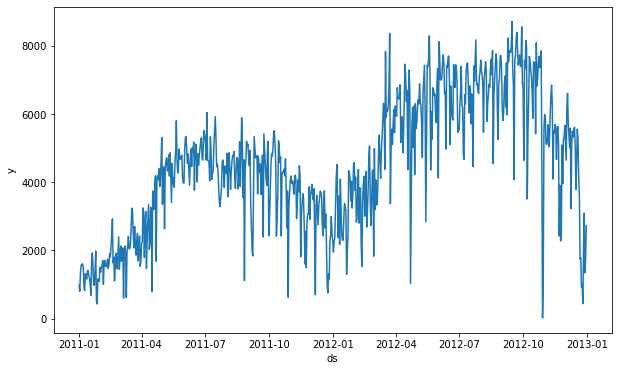

In [5]:
plt.figure(figsize = (10,6))
sns.lineplot(x = df['ds'], y=df['y']);

In [6]:
print(df[df['holiday']==1].shape)
df[df['holiday']==1][:5]

(21, 9)


,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
16,2011-01-17,1000,1,0,2,0.175833,0.176771,0.537500,0.194017
51,2011-02-21,1107,1,0,2,0.303333,0.284075,0.605000,0.307846
104,2011-04-15,3126,1,0,1,0.446667,0.441913,0.671250,0.226375
149,2011-05-30,4098,1,0,1,0.733333,0.671092,0.685000,0.131225
184,2011-07-04,6043,1,0,2,0.726667,0.665417,0.637917,0.081479


In [7]:
holidays = pd.DataFrame({'holiday':'holi',
                         'ds': df[df['holiday']==1]['ds'],
                         'lower_window':-3,
                         'upper_window':1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [8]:
# Train, Test split
test_period = 31
train = df.iloc[:-test_period,:].drop(columns = 'holiday')
test  = df.iloc[-test_period:,:].drop(columns = 'holiday')
print(train.shape, test.shape)
display(test.tail(2))

(700, 8) (31, 8)


,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
729,2012-12-30,1796,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,2729,1,2,0.215833,0.223487,0.577500,0.154846


### >> Prophet model

In [9]:
model = Prophet(growth = 'linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays=holidays,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=20,
                holidays_prior_scale=20,
                changepoint_prior_scale=0.01)
model.add_regressor('workingday')
model.add_regressor('weathersit')
model.add_regressor('temp')
model.add_regressor('atemp')
model.add_regressor('hum')
model.add_regressor('windspeed')

In [10]:
model.fit(train)

### >> Model Forecast

In [11]:
# create dataset with 'data-stamps' - including past and future
X_df = model.make_future_dataframe(periods = len(test), freq='D')
X_df.shape

(731, 1)

In [12]:
X_df.head(2)

,ds
0,2011-01-01
1,2011-01-02


In [13]:
# merge external regressors
X_df = pd.concat([X_df, df.drop(columns=['ds','y','holiday'])], axis = 1)
X_df.head(2)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,0,2,0.363478,0.353739,0.696087,0.248539


In [14]:
forecast = model.predict(X_df)
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2477.353019,320.029245,2219.942181,2477.353019,2477.353019,-0.055318,-0.055318,-0.055318,-0.283354,-0.283354,-0.283354,0.0,0.0,0.0,0.0,0.0,0.0,-0.073838,-0.073838,-0.073838,-0.500493,-0.500493,-0.500493,-0.092727,-0.092727,-0.092727,-0.082024,-0.082024,-0.082024,0.053070,0.053070,0.053070,0.020554,0.020554,0.020554,0.0,0.0,0.0,-0.270210,-0.270210,-0.270210,0.0,0.0,0.0,1237.455128
1,2011-01-02,2482.773408,100.081694,1903.915888,2482.773408,2482.773408,-0.059974,-0.059974,-0.059974,-0.291619,-0.291619,-0.291619,0.0,0.0,0.0,0.0,0.0,0.0,-0.028912,-0.028912,-0.028912,-0.598647,-0.598647,-0.598647,-0.081455,-0.081455,-0.081455,-0.082024,-0.082024,-0.082024,-0.044262,-0.044262,-0.044262,-0.039253,-0.039253,-0.039253,0.0,0.0,0.0,-0.262766,-0.262766,-0.262766,0.0,0.0,0.0,996.469042


In [15]:
forecast['yhat'][-test_period:]

700    4122.797902
701    3500.425268
702    5620.561787
703    5601.226735
704    5305.461428
705    4742.701792
706    3908.718181
707    4128.226463
708    3267.047143
709    3661.226941
710    3584.650149
711    3902.872113
712    4816.127091
713    4552.788735
714    4947.501901
715    3195.290732
716    3472.400760
717    4609.237037
718    4296.048515
719    3522.463788
720    2667.673323
721    3296.034436
722    3370.657194
723    2389.316832
724    1930.644198
725     117.095487
726    1792.693732
727    2960.213459
728    2720.152241
729    2675.100625
730    2585.993493
Name: yhat, dtype: float64

In [16]:
preds = pd.Series(forecast['yhat'][-test_period:].values, index = test['ds'].values)
preds[:5]

2012-12-01    4122.797902
2012-12-02    3500.425268
2012-12-03    5620.561787
2012-12-04    5601.226735
2012-12-05    5305.461428
dtype: float64

In [17]:
print('Average level: ', round(df['y'].mean(),0))
print('MAE:  ', mean_absolute_error(test['y'], preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['y'], preds)).round(0))
print('MAPE: ', round(((test['y'] - preds.values)/test['y']).abs().mean()*100,2))

Average level:  4504.0
MAE:   906.0
RMSE:  1030.0
MAPE:  34.09


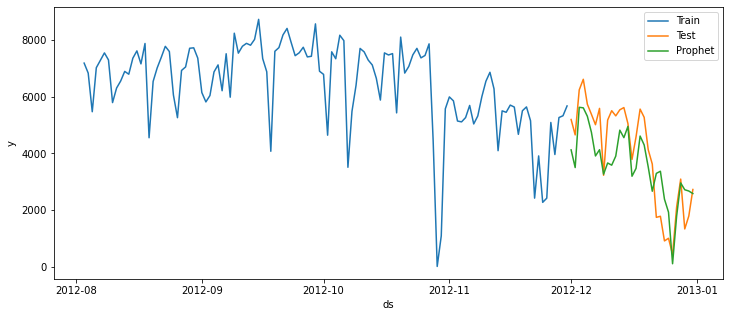

In [18]:
plt.figure(figsize = (12,5))
sns.lineplot(data = train[-120:], x='ds', y='y', label='Train')
sns.lineplot(data = test, x='ds', y='y', label='Test' )
sns.lineplot(x = preds.index, y = preds.values, label='Prophet')
plt.legend(loc='best');

## Stage 2 - XGBoost Model

In [19]:
# Extracting Prophet's fitted model variables of interest - to augment original features
cols = ['trend', 'holi', 'weekly', 'yearly']
prophet_variables = forecast.loc[:,cols]
xgb_df = pd.concat( [df.drop(columns='holiday'),prophet_variables], axis=1)
xgb_df.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2477.353019,0.0,0.053070,-0.270210
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2482.773408,0.0,-0.044262,-0.262766
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2488.193796,0.0,-0.024677,-0.253971
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2493.614184,0.0,0.001114,-0.243958
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2499.034572,0.0,-0.003566,-0.232881


In [20]:
# Train, Test split
test_period = 31
train_xgb = xgb_df.iloc[:-test_period,:]
test_xgb  = xgb_df.iloc[-test_period:,:]
print(train_xgb.shape, test_xgb.shape)
display(test_xgb.tail(2))

(700, 12) (31, 12)


,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
729,2012-12-30,1796,0,1,0.255833,0.231700,0.483333,0.350754,6428.809689,0.0,-0.044262,-0.278614
730,2012-12-31,2729,1,2,0.215833,0.223487,0.577500,0.154846,6434.230065,0.0,-0.024677,-0.273390


In [21]:
# Separate X & Y
y_train = train_xgb['y']
y_test  = test_xgb['y']
X_train = train_xgb.drop(columns = ['ds', 'y'])
X_test  = test_xgb.drop(columns = ['ds', 'y'])
print(y_train.shape, y_test.shape, X_train.shape, X_test.shape)

(700,) (31,) (700, 10) (31, 10)


In [22]:
model = xgb.XGBRegressor(max_depth=3, 
                         learning_rate=0.1, 
                         use_label_encoder=False, 
                         eval_metric='rmse',
                         objective='reg:squarederror',
                         n_estimators=100) #,early_stopping_rounds=10)

# Objective functions: https://xgboost.readthedocs.io/en/stable/parameter.html 
    
val_test = [(X_test, y_test)]

In [23]:
model.fit(X_train, y_train, eval_set=val_test, verbose=10)

[0]	validation_0-rmse:3891.58894
[10]	validation_0-rmse:1868.58752
[20]	validation_0-rmse:1443.42856
[30]	validation_0-rmse:1354.64504
[40]	validation_0-rmse:1276.28282
[50]	validation_0-rmse:1236.33411
[60]	validation_0-rmse:1194.74352
[70]	validation_0-rmse:1187.69443
[80]	validation_0-rmse:1181.29683
[90]	validation_0-rmse:1193.42533
[99]	validation_0-rmse:1184.49998


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [24]:
preds_xgb = pd.Series(model.predict(X_test), index = test_xgb['ds'])
preds_xgb[:5]

ds
2012-12-01    3830.047607
2012-12-02    2749.846436
2012-12-03    6315.544434
2012-12-04    6338.417969
2012-12-05    6057.785645
dtype: float32

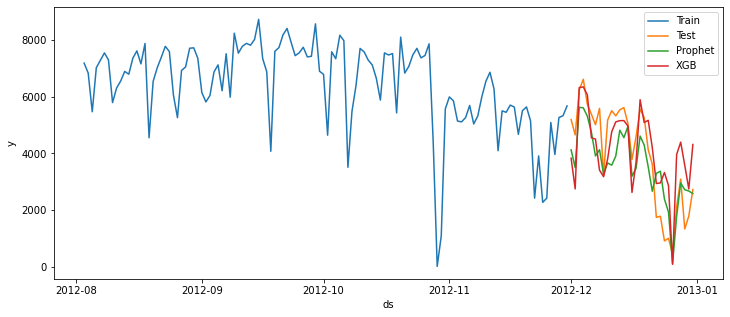

In [25]:
plt.figure(figsize = (12,5))
sns.lineplot(data = train[-120:], x='ds', y='y', label='Train')
sns.lineplot(data = test, x='ds', y='y', label='Test' )
sns.lineplot(x = preds.index, y = preds.values, label='Prophet')
sns.lineplot(x = preds_xgb.index, y = preds_xgb.values, label='XGB')
plt.legend(loc='best');

In [26]:
print('Average level: ', round(df['y'].mean(),0))
print('MAE:  ', mean_absolute_error(test['y'], preds_xgb).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['y'], preds_xgb)).round(0))
print('MAPE: ', round(((test['y'] - preds_xgb.values)/test['y']).abs().mean()*100,2))

Average level:  4504.0
MAE:   962.0
RMSE:  1184.0
MAPE:  44.16


In [27]:
preds_xgb.to_csv('preds_prophet_XGB.csv')